In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import particlesim.api
import particlesim.helpers_for_tests
import particlesim.utils.xyz
import particlesim.utils.config_parser
import particlesim.utils.conversion
from particlesim.k_cython import fast_distances, fast_distances_cpdef
from particlesim.neighbouring import NeighbouringCellLinkedLists, NeighbouringPrimitiveLists
import time
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def create_system_conf_with_na_and_cl(num_na, num_cl, box_size = 12, neighbouring=False):
    particles = particlesim.helpers_for_tests.create_positions(box_size=box_size,number_of_particles=num_na+num_cl)
    na = {'sigma':1.21496,'epsilon':0.0469,'charge':1}
    cl = {'sigma':2.02234, 'epsilon':0.15,'charge':-1.0}
    return particlesim.api.SystemConfiguration(xyz=particles, 
                                                      sigmas=([na['sigma']]*num_na)+([cl['sigma']]*num_cl),
                                                      epsilons=[na['epsilon']]*num_na+[cl['epsilon']]*num_cl,
                                                      charges=[na['charge']]*num_na+[cl['charge']]*num_cl,
                                                      box_size=box_size, neighbouring=neighbouring)

<IPython.core.display.Javascript object>


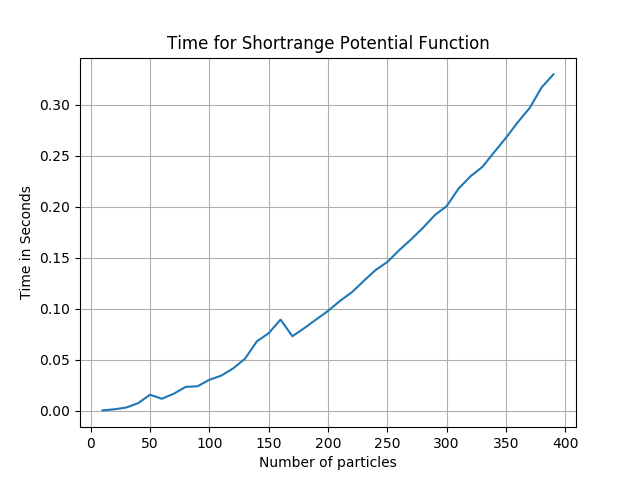

In [11]:
"""This is the ENTIRE SHORTRANGE FUNCTION!!! Fast cython neighborlists but ALWAYS N^2 RUNTIME"""
nr_particles, times = [], []
N = 400
for i in range(10,N,N//40):
    sys_conf = create_system_conf_with_na_and_cl(i//2,i//2,16,neighbouring=False)
    shorty = sys_conf._total_potential.shortrange
    st = time.clock()
    pot = shorty.shortrange(sys_conf.xyz)
    end = time.clock()
    times.append(end-st); nr_particles.append(i)
    #print(i, "particles, time: ", end-st, " potential= ", pot)
plt.close()
plt.title("Time for Shortrange Potential Function");plt.ylabel("Time in Seconds");plt.xlabel("Number of particles")
plt.plot(nr_particles, times); plt.grid()

10 particles, time:  0.013964999999984684  potential=  -31.4086220114
12 particles, time:  0.014780000000030213  potential=  -68.9729247254
14 particles, time:  0.019770999999991545  potential=  -6.21141123662
16 particles, time:  0.025228000000026896  potential=  -7.0649909922
18 particles, time:  0.031135999999946762  potential=  -323.931403082
20 particles, time:  0.033975999999995565  potential=  22.8427515762
22 particles, time:  0.04773499999998876  potential=  16.9913338971
24 particles, time:  0.050129000000026736  potential=  25.8992925446
26 particles, time:  0.056409000000030574  potential=  587.914131352
28 particles, time:  0.06586799999996629  potential=  -21.2242161721
30 particles, time:  0.07999499999999671  potential=  135.036482105
32 particles, time:  0.1093529999999987  potential=  151.24252974
34 particles, time:  0.11729199999996354  potential=  1023121007.06
36 particles, time:  0.10802200000000539  potential=  156.41438199
38 particles, time:  0.114034000000003

<IPython.core.display.Javascript object>


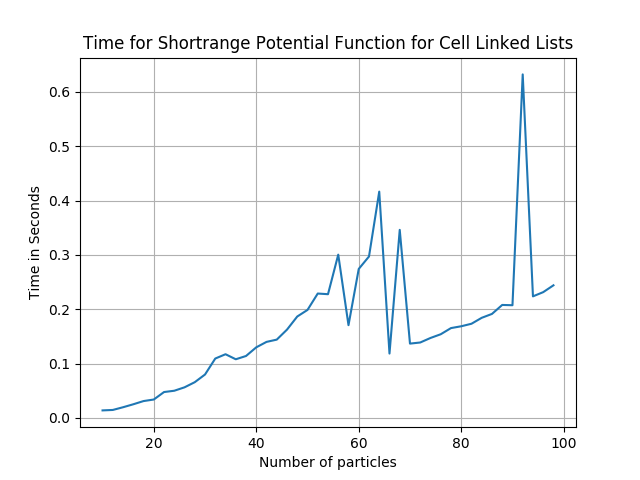

In [14]:
"""This is the ENTIRE SHORTRANGE FUNCTION!!! Python CellLL but ALWAYS N^2 RUNTIME"""
nr_particles, times = [], []
N = 100
for i in range(10,N,(N//40)):
    # means we're using cell linked lists
    sys_conf = create_system_conf_with_na_and_cl(i//2,i//2,16,neighbouring=True)
    shorty = sys_conf._total_potential.shortrange
    st = time.clock()
    pot = shorty.shortrange(sys_conf.xyz)
    end = time.clock()
    times.append(end-st); nr_particles.append(i)
    print(i, "particles, time: ", end-st, " potential= ", pot)
plt.close()
plt.title("Time for Shortrange Potential Function for Cell Linked Lists")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
plt.plot(nr_particles, times)
plt.grid()
plt.show()

Time:  0.003444000000001779
Time:  0.02800799999999981
Time:  0.08058700000003682
Time:  0.15874800000000278
Time:  0.25269399999996267
Time:  0.38337900000004765
Time:  0.483524999999986
Time:  0.6791390000000206
Time:  0.7780179999999746
Time:  1.0343479999999659
Time:  1.137563
Time:  1.698995000000025


<IPython.core.display.Javascript object>


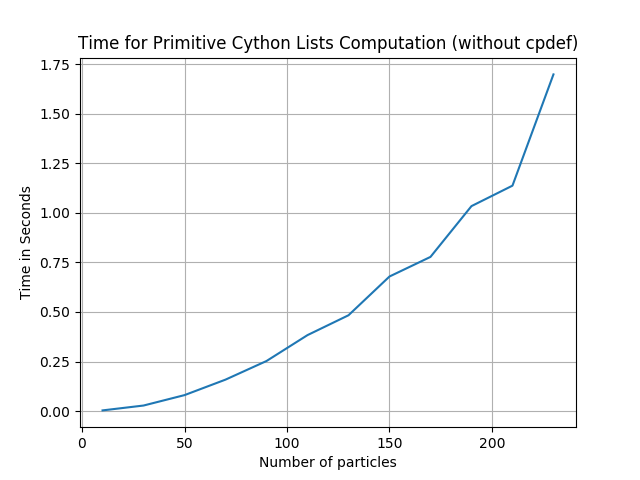

In [17]:
"""This is a Primitive List Neighbour Structure in Python"""
box_len = 5
nr_part = 250
nr_particles, times = [], []
for i in range(10, nr_part, 20):
    #dists = np.zeros((i,i))
    #pos = np.random.rand(nr_part,3)
    pos = np.arange(i*3).reshape(i,3).astype("float")%box_len
    
    st = time.clock()
    neigh_list = NeighbouringPrimitiveLists(pos, 1.2, 5)
    end = time.clock()
    nr_particles.append(i); times.append(end-st)
    print("Time: ", end-st)
    
plt.close()
plt.title("Time for Primitive Cython Lists Computation (without cpdef)")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
nr_particles = np.array(nr_particles); times = np.array(times)
plt.plot(nr_particles, times)
plt.grid()
plt.show()

Time:  2.9000000040468876e-05
Time:  6.600000000389628e-05
Time:  8.50000000127693e-05
Time:  0.00011699999998882049
Time:  0.00019800000001168883
Time:  0.00026800000000548607
Time:  0.000367999999980384
Time:  0.00050000000004502
Time:  0.0006359999999858701
Time:  0.0013250000000084583
Time:  0.0018760000000384025
Time:  0.0014970000000289474
Time:  0.0014529999999695065
Time:  0.0018000000000029104
Time:  0.001886000000013155
Time:  0.002112000000010994
Time:  0.002685000000042237
Time:  0.0032099999999672946
Time:  0.003080000000011296
Time:  0.0044980000000123255
Time:  0.004186000000004242
Time:  0.005612999999982549
Time:  0.004543000000012398
Time:  0.004993000000013126
Time:  0.005267000000003463
Time:  0.005786999999997988
Time:  0.00623400000000629
Time:  0.00724299999995992
Time:  0.00796900000000278
Time:  0.008766000000036911
Time:  0.0090979999999945
Time:  0.010073999999974603
Time:  0.009477000000003954
Time:  0.009897000000023581
Time:  0.011034999999992579
Time:  0.

<IPython.core.display.Javascript object>


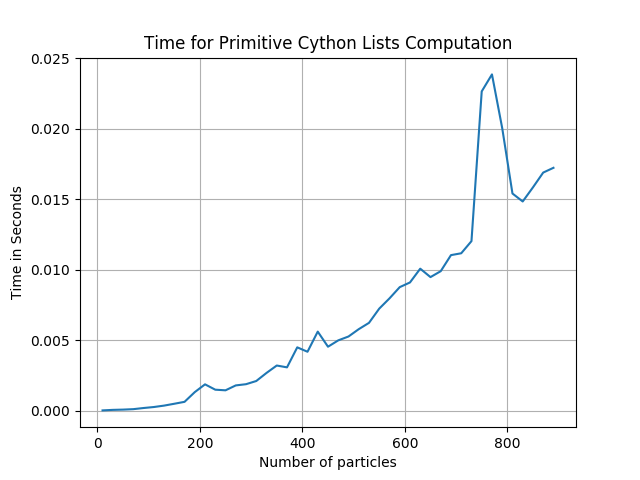

In [16]:
"""This is a Primitive List Structure in CYTHON"""
box_len = 5
nr_part = 900
nr_particles, times = [], []
for i in range(10, nr_part, 20):
    dists = np.zeros((i,i))
    #pos = np.random.rand(nr_part,3)
    pos = np.arange(i*3).reshape(i,3).astype("float")%box_len
    
    st = time.clock()
    fast_distances_cpdef(pos, box_len, dists)
    end = time.clock()
    nr_particles.append(i); times.append(end-st)
    print("Time: ", end-st)
    
plt.close()
plt.title("Time for Primitive Cython Lists Computation")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
nr_particles = np.array(nr_particles); times = np.array(times)
plt.plot(nr_particles, times)
plt.grid()
plt.show()

Time:  0.004498999999981379
Time:  0.04286100000001625
Time:  0.0871569999999906
Time:  0.15390800000000127
Time:  0.23383300000000418
Time:  0.37453300000001377
Time:  0.5081470000000081
Time:  0.6538940000000082
Time:  0.8981630000000109
Time:  1.0109510000000057
Time:  1.3333279999999945
Time:  1.4703130000000044
Time:  1.6680980000000147
Time:  1.992477000000008
Time:  2.2481679999999926
Time:  2.582788999999991
Time:  2.8249099999999885
Time:  3.2903239999999983
Time:  3.4874189999999885
Time:  4.145990000000012
Time:  4.642695000000003
Time:  6.3799800000000175
Time:  5.557607000000019
Time:  5.999121000000002
Time:  6.2066749999999615


<IPython.core.display.Javascript object>


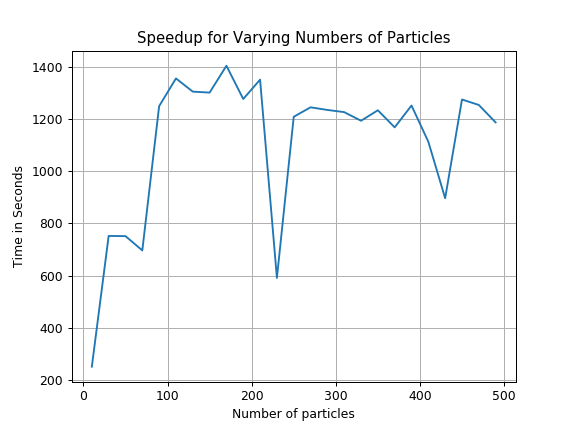

In [13]:
"""Achieved Speedup"""
box_len = 5
nr_part = 300
nr_particles, times = [], []
for i in range(10, nr_part, 20):
    dists = np.zeros((i,i))
    #pos = np.random.rand(nr_part,3)
    pos = np.arange(i*3).reshape(i,3).astype("float")%box_len
    
    st = time.clock()
    fast_distances_cpdef(pos, box_len, dists)
    end = time.clock()
    nr_particles.append(i); times.append(end-st)
    st = time.clock()
    neigh_list = NeighbouringPrimitiveLists(pos, 1.2, box_len)
    end = time.clock()
    times[-1] = (end-st)*1.0/times[-1]
    print("Time: ", end-st)
    
plt.close()
plt.title("Speedup for Varying Numbers of Particles")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
nr_particles = np.array(nr_particles); times = np.array(times)
plt.plot(nr_particles, times)
plt.grid()
plt.show()

Time:  0.0008100000000013097
Time:  0.0009709999999927277
Time:  0.0013950000000022555
Time:  0.0017889999999738393
Time:  0.002426000000014028
Time:  0.002846000000033655
Time:  0.003747999999973217
Time:  0.0036999999999807187
Time:  0.005126000000018394
Time:  0.005462999999963358
Time:  0.002296000000001186
Time:  0.0023939999999811334
Time:  0.0025420000000053733
Time:  0.002751999999986765
Time:  0.0028599999999983083
Time:  0.007903000000055727
Time:  0.0033819999999877837
Time:  0.009066000000018448
Time:  0.009741999999960171
Time:  0.01045699999997396
Time:  0.004462000000046373
Time:  0.011660000000006221
Time:  0.006843000000003485
Time:  0.00924800000001369
Time:  0.008274999999969168
Time:  0.008692999999993845
Time:  0.009485999999981232
Time:  0.005205999999986943
Time:  0.005446000000006279
Time:  0.005502000000035423
Time:  0.0059560000000260516
Time:  0.010685999999964224
Time:  0.0060330000000021755
Time:  0.006581000000039694
Time:  0.006420999999988908
Time:  0.01

<IPython.core.display.Javascript object>


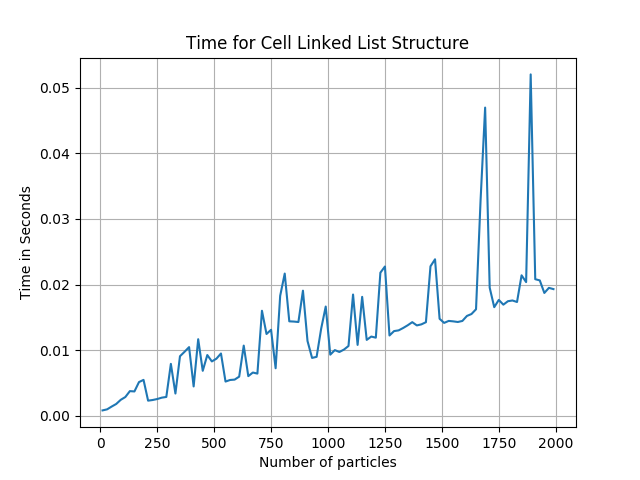

In [36]:
"""This is a CELL LINKED List Neighbour Structure in Python"""
box_len = 10
nr_part = 2000
nr_particles, times = [], []
for i in range(10, nr_part, 20):
    #dists = np.zeros((i,i))
    #pos = np.random.rand(nr_part,3)*box_len
    pos = np.arange(i*3).reshape(i,3).astype("float")%box_len
    
    st = time.clock()
    neigh_list = NeighbouringCellLinkedLists(pos, 1.2, box_len)
    end = time.clock()
    nr_particles.append(i); times.append(end-st)
    print("Time: ", end-st)
    
plt.close()
plt.title("Time for Cell Linked List Structure")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
nr_particles = np.array(nr_particles); times = np.array(times)
times2 = (times[2:]+times[1:-1]+times[:-2])/3.0
#plt.plot(nr_particles[:-2], times2)
plt.plot(nr_particles, times)
plt.grid()
plt.show()